# Porting LSST test queries to Stripe82++ : part 1

Notebook with queries representing the LSST test queries, but against the Stripe82 database. The latter was extended with a 'match' and 'coadd' table following script in 
https://docs.google.com/document/d/1qFOE1s4bQUDM8W7wLzoxb2OK1LaPwzd5Lmy_GKUYut0.

Queries from https://dev.lsstcorp.org/trac/wiki/db/queries, first batch:
* Extract light curve for a given object (time, magnitude and/or position) 
* Select the full color image of a single (given) galaxy 
* Find an object with a particular objectId 
* Select variable objects near a known galaxy 
* Give me astrometry for a given moving object 

Assuming schema S12_sdss from https://lsst-web.ncsa.illinois.edu/schema/index.php?sVer=S12_sdss

Ths notebook is in https://github.com/idies/jhu-lsst/blob/master/Stripe82/test_queries/LSST-Test-Queries%20-%20Part%201.ipynb

In [2]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import skimage.io                   # image processing library

In [3]:
import SciServer.CasJobs as cj

In [4]:
import SciServer.SkyServer as skyS

In [5]:
# define some variable to be used in query execution

TARGET_CONTEXT="Stripe82_016"

In [30]:
# SLOW
# We should add more columns to coadd
sql="""
SELECT TOP 16 p.objId,c.ra,c.dec,p.petror90_r
  FROM test.coadd as c
  inner join photoobjall AS p
  on c.cobjid=p.objid
  and c.type=3
  and c.u BETWEEN 0 AND 19.6
  AND c.g BETWEEN 0 AND 17
  AND p.petror90_r > 10
"""
df=cj.executeQuery(sql,TARGET_CONTEXT)
df.head(3)

,objId,ra,dec,petror90_r
0,8647474690327707860,-15.410634,-1.183950,14.83797
1,8647474690330001465,-10.275765,-1.060240,23.09696
2,8647474690340618618,14.095148,-1.209754,13.53837


In [31]:
OBJECT_ID=df['objId'][1]

### <a href="https://dev.lsstcorp.org/trac/wiki/db/queries/001" target="_blank">Extract light curve for a given object (time, magnitude and/or position) </a>

https://dev.lsstcorp.org/trac/wiki/db/queries/001

QSERV
```sql
SELECT taiMidPoint, psfFlux, psfFluxSigma, ra, decl
FROM   Source
JOIN   Filter USING (filterId)
WHERE  objectId = :objectId
   AND filterName = :filterName
```

In [22]:
# LSST schema apparently has one row per filter, SDSS does not.
# Maybe we should make a version of Source similar to the LSST schema.

sql="""
select s.cobjid,p.objid,distance,p.ra,p.dec
  , p.psfMag_u, p.psfMagErr_u, f.mjd_u
  , p.petroMag_u, p.petroMagErr_u, p.modelMag_u, p.modelMagErr_u
  , p.psfMag_g, p.psfMagErr_g, f.mjd_g
  , p.psfMag_r, p.psfMagErr_r, f.mjd_r
  , p.psfMag_i, p.psfMagErr_i, f.mjd_i
  , p.psfMag_z, p.psfMagErr_z, f.mjd_z
  from test.coadd o
    inner join test.match s
       on s.cobjid=o.cobjid
    inner join field f
       on f.fieldid=s.fieldid
    inner join PhotoobjAll p
       on s.objId=p.objid
 where o.cobjId=%d
order by f.mjd_u
""" % OBJECT_ID
df=cj.executeQuery(sql,TARGET_CONTEXT)
df.head()

,cobjid,objid,distance,ra,dec,psfMag_u,psfMagErr_u,mjd_u,petroMag_u,petroMagErr_u,...,mjd_g,psfMag_r,psfMagErr_r,mjd_r,psfMag_i,psfMagErr_i,mjd_i,psfMag_z,psfMagErr_z,mjd_z
0,8647474690327707860,8658177821842145383,0.001490,344.589382,-1.183970,18.92645,0.026845,51819.312002,16.80047,0.031515,...,51819.313660,16.51726,0.018303,51819.310343,15.95949,0.024988,51819.311172,15.72155,0.019236,51819.312831
1,8647474690327707860,8658466190240383053,0.000715,344.589372,-1.183940,18.89199,0.025899,52552.268881,16.73602,0.035037,...,52552.270540,16.22957,0.012581,52552.267223,15.93232,0.011359,52552.268052,15.51334,0.023775,52552.269711
2,8647474690327707860,8658185033090727976,0.001323,344.589381,-1.183934,18.71248,0.026212,52577.164951,16.79950,0.030432,...,52577.166610,16.09065,0.020014,52577.163293,15.71718,0.019666,52577.164122,15.48258,0.012093,52577.165780
3,8647474690327707860,8658185166226784369,0.000847,344.589377,-1.183941,18.93591,0.021324,52586.168230,16.80994,0.027172,...,52586.169889,16.32167,0.013568,52586.166572,15.90809,0.019703,52586.167401,15.63155,0.019775,52586.169060
4,8647474690327707860,8658188335923986499,0.001823,344.589389,-1.183931,19.01374,0.023794,52935.176048,16.77078,0.031954,...,52935.177707,16.51669,0.015535,52935.174390,16.11238,0.018626,52935.175219,15.59756,0.022005,52935.176877


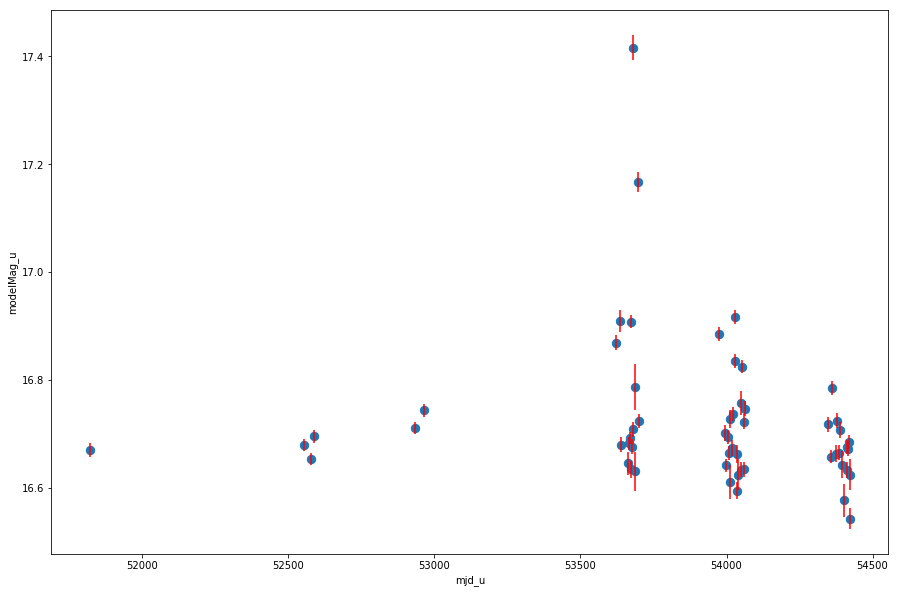

In [23]:
f=plt.figure(figsize=(15,10))
x="mjd_u"
y="psfMag_u"
yerr="psfMagErr_u"
y="petroMag_u"
yerr="petroMagErr_u"
y="modelMag_u"
yerr="modelMagErr_u"
plt.scatter(df[x],df[y],s=70)
plt.errorbar(df[x],df[y],yerr=df[yerr], linestyle="None",c='red')
plt.xlabel(x)
plt.ylabel(y);

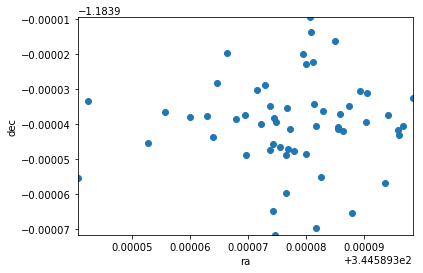

In [9]:
x="ra"
y="dec"
plt.scatter(df[x],df[y])
xlim=(np.min(df[x]),np.max(df[x]))
ylim=(np.min(df[y]),np.max(df[y]))
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel(x)
plt.ylabel(y)

# TODO
create tables mimicking the LSST schema more closely, in particular Source and Filter tables. Source with one flux and an explicit filter identifier.

### <a href="https://dev.lsstcorp.org/trac/wiki/db/queries/006" target="_blank">Select the full color image of a single (given) galaxy</a>

QSERV

To complete this request we need to run a database query that selects the galaxy based on a given objectId, determines its ra, decl and size as well as corresponding exposureId. Since the epoch is not specified, the most recent one will be fetched.
Generate image cut out through Cutout Service.
The database query:

```sql
SELECT s.ra, s.decl, o.raRange, o.declRange
FROM   Object o
JOIN   Source s USING (objectId)
WHERE  o.objectId = :objectId
AND    o.latestObsTime = s.taiMidPoint
```

In [27]:
# we will do this using the cutout service url that is provided and connect to skyserver to get it.
sql="""
select top 1 p.ra, p.dec, p.petror90_r
  from test.coadd o
    inner join test.match s
       on s.cobjid=o.cobjid
    inner join field f
       on f.fieldid=s.fieldid
    inner join PhotoobjAll p
       on s.objId=p.objid
 where o.cobjId=%d
order by f.mjd_u asc
""" % OBJECT_ID
df= cj.executeQuery(sql,TARGET_CONTEXT)

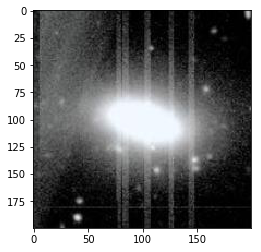

In [28]:
# NB only co-added multi color images are available, not one for each field
width=200
height=200
pixelsize=0.396

ra=df['ra'][0]
dec= df['dec'][0]
petror90_r=df['petror90_r'][0]

# the 'scale' parameter is set so that the image will be about 2x the size of the galaxy
scale=2*petror90_r/pixelsize/width
if False:
    img=skyS.getJpegImgCutout(ra,dec, scale=scale, width=width, height=height, opt="", query="", dataRelease='DR13')
else:
    url="http://skyservice.pha.jhu.edu/Stripe82/ImgCutout/getjpeg.aspx?ra="+str(ra)
    url+="&dec="+str(dec)+"&scale="""+str(scale)+"&width="+str(width)
    url+="&height="+str(height)
    img=skimage.io.imread(url)
plt.imshow(img);

### <a href="" target="_blank"> Find an object with a particular objectId</a>

QSERV
```sql
SELECT *
FROM   Object
WHERE  objectId = :objectId
```
Origin: this query came from SDSS (SX-4).


In [21]:
# this query should try to get the columns similar to the one in the lSST schema.
# I.e. this might a good sample query to base a possible test.Object view on...
sql="""
select * from test.coadd
where cobjId=%d""" % OBJECT_ID
df=cj.executeQuery(sql,TARGET_CONTEXT)
df

,cobjid,type,ra,dec,cx,cy,cz,u,g,r,i,z,c,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z
0,8647474690327707860,3,-15.410634,-1.18395,0.96384,-0.265678,-0.020662,18.647,16.94054,16.27464,15.95672,15.60708,2.348373,0.005046,0.000817,0.000582,0.000595,0.001111


### <a href="" target="_blank">Select variable objects near a known galaxy

QSERV
```sql
SELECT v.objectId, v.ra, v.decl
FROM   Object v, Object o
WHERE  o.objectId = :objectId
   AND spDist(v.ra, v.decl, o.ra, o.decl, :dist)
   AND v.variability > 0.8
   AND o.extendedParameter > 0.8
```



# NB
Note, none of the Object tables in the different versions of the schema in https://lsst-web.ncsa.illinois.edu/schema/index.php has a 'variability' column. We might calculate these from the schemas using some algorithm, but in principle query could be replaced by another selecting on other columns.

Stripe82 schema also has not such columns, so we will ignore it and simply focus on the "near" query. Here we will not do the simple distance calculation as that will be slow.

Btw, CLR was not enabled yet on the database.


In [33]:
DIST=.1 # arcmin
sql="""
select v.cobjId, v.ra, v.dec
  from test.coadd o
  ,    test.coadd v
 where o.cobjId=%d
   and dbo.fDistanceEq(o.ra,o.dec,v.ra,v.dec) <= %s
   """ % (OBJECT_ID, DIST)
%time df=cj.executeQuery(sql,TARGET_CONTEXT)
df

Exception: Error when executing query. Http Response from CasJobs API returned status code 500:
{"Error Code":500,"Error Type":"InternalServerError","Error Message":"Failed to execute a query: An error occurred in the Microsoft .NET Framework while trying to load assembly id 65539. The server may be running out of resources, or the assembly may not be trusted with PERMISSION_SET = EXTERNAL_ACCESS or UNSAFE. Run the query again, or check documentation to see how to solve the assembly trust issues. For more information about this error: \r\nSystem.IO.FileLoadException: Could not load file or assembly 'sphericalhtm, Version=0.0.0.0, Culture=neutral, PublicKeyToken=null' or one of its dependencies. An error relating to security occurred. (Exception from HRESULT: 0x8013150A)\r\nSystem.IO.FileLoadException: \r\n   at System.Reflection.RuntimeAssembly._nLoad(AssemblyName fileName, String codeBase, Evidence assemblySecurity, RuntimeAssembly locationHint, StackCrawlMark& stackMark, IntPtr pPrivHostBinder, Boolean throwOnFileNotFound, Boolean forIntrospection, Boolean suppressSecurityChecks)\r\n   at System.Reflection.RuntimeAssembly.InternalLoadAssemblyName(AssemblyName assemblyRef, Evidence assemblySecurity, RuntimeAssembly reqAssembly, StackCrawlMark& stackMark, IntPtr pPrivHostBinder, Boolean throwOnFileNotFound, Boolean forIntrospection, Boolean suppressSecurityChecks)\r\n   at System.Reflection.RuntimeAssembly.InternalLoad(String assemblyString, Evidence assemblySecurity, StackCrawlMark& stackMark, IntPtr pPrivHostBinder, Boolean forIntrospection)\r\n   at System.Reflection.RuntimeAssembly.InternalLoad(String assemblyString, Evidence assemblySecurity, StackCrawlMark& stackMark, Boolean forIntrospection)\r\n   at System.Reflection.Assembly.Load(String assemblyString)\r\n","LogMessageID":"3d7a8e2a-3b6b-40b9-96f6-8322cce53636"}

,objId,ra,dec,petror90_r
0,8647474690327707860,-15.410634,-1.183950,14.83797
1,8647474690330001465,-10.275765,-1.060240,23.09696
2,8647474690340618618,14.095148,-1.209754,13.53837
3,8647474690341535789,16.069998,-1.074973,12.38839
4,8647474690343895145,21.510473,-1.225606,26.74715
5,8647474690344091683,21.899593,-1.105094,16.29971
6,8647474690344091714,21.929203,-1.139579,19.55241
7,8647474690344288366,22.433274,-1.241417,21.70089
8,8647474690351431751,38.672722,-1.238498,12.65033
9,8647474690355495079,48.053608,-1.061901,15.45670


In [34]:
sql

'\nselect v.cobjId, v.ra, v.dec\n  from test.coadd o\n  ,    test.coadd v\n where o.cobjId=8647474690330001465\n   and dbo.fDistanceEq(o.ra,o.dec,v.ra,v.dec) <= 0.1\n   '

In [32]:
# as coadd has no htm column (yet) go through photoobjal, but filter on objects being head of a match (i.e. in coadd) 
sql="""
select v.objid,v.ra,v.dec 
 from test.coadd o cross apply dbo.fHtmCoverCircleEq( o.ra,o.dec,%s) htm
     inner join photoobjall p
       on p.htmId between htm.htmidstart and htmidend
      inner join test.coadd v
        on v.cobjid=p.objis
       and dbo.fDistanceEq(o.ra,o.dec,v.ra,v.dec) <= %s
 where o.cobjid=%s
""" % (DIST, DIST, OBJECT_ID)
df=cj.executeQuery(sql,TARGET_CONTEXT)
df

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



NameError: name 'DIST' is not defined

# TODO
add htmId column to coadd (and match?) so we do not have to go through photoobjall

### <a href="" target="_blank">Give me astrometry for a given moving object</a>

This query was suggested by the LSST Science Collaboration (Solar System)

QSERV
```sql
SELECT diaSourceId, ra, decl
FROM   DiaSource
WHERE  movingObjectId = :movingObjectId
```

Note: DiaSource  = "Table to store 'difference image sources'; - sources detected at SNR >=5 on difference images."

In [ ]:
# Moving objects are found on difference images. Do we have such in Stripe82?
# Can we create a table like DiaSOurce from our coadd/match tables?


# RESULT: FAIL
need to have a table with moving objects, DiaSource

# Simulating LSST schema:

LSST::Source, only for u-band, others treated same
```sql
CREATE TABLE Filter as (filterId tinyint not null, name char(1) not null)
GO

INSERT INTO Filter VALUES (1,'u'),(2,'g'),(3,'r'),(4,'i'),(5,'z')
GO

-- TODO create table statement for SOurce
INSERT INTO Source
select top 10 m.objId as sourceid,  p.parentId as parentsourceId, p.fieldId as scienceCcdExposureId
,      1 as filterId  -- 2 for g etc
,      f.mjd_u as timeMid -- start, not mid point of exposure  
,      -999 as expTime  -- TODO proper value 
,      o.cobjid as objectId, o.ra as objectRa, o.dec as objectDecl
,      p.ra+p.offsetRA_u/cos(radians(p.dec))/3600 as ra   -- TBD check dec not +/- 90
,      p.dec+p.offsetDec_u/3600 as decl
,      .1 as raVar, .1 as declVar, 0 as radeclCov   -- SDSS schema has no individual errors on position, correct?
,      p.htmId as htmId20 
,      p.rowc_u as x       -- should this be isoRowc_u etc
,      p.colc_u as y       -- ,,
,      p.rowcErr_u as xVar -- ,,
,      p.colcErr_u as yVar -- ,,
,      p.psfMag_u as psfMag,  psfMagErr_u as psfMagErr -- need fluxes!
,      NULL as apFLux, NULL as apFluxSigma     -- TODO can values be found?
,      p.modelMag_u as modelFLux, p.modelMagErr_u as modelFluxSigma
,      NULL as instFLux, NULL as instFluxSigma -- TODO can values be found?
,      
  from test.match m
     inner join photoobjall p
        on p.objid=m.objid
     inner join field f
        on f.fieldId=o.fieldId
     left outer join test.coadd o 
        on o.cobjid=m.cobjid
```


next 
```sql
union
  select m.*,'g' , p.psfMag_g , psfMagErr_g 
from lsst_source m
  , photoobjall p
where p.objid=m.sourceId
  union
  select m.*,'r' , p.psfMag_r , psfMagErr_r  
from lsst_source m
  , photoobjall p
where p.objid=m.sourceId
    union
  select m.*,'i' , p.psfMag_i ,  psfMagErr_i  
from lsst_source m
  , photoobjall p
where p.objid=m.sourceId
  union
  select m.*,'z' , p.psfMag_z , psfMagErr_z  
from lsst_source m
  , photoobjall p
  where p.objid=m.sourceId
```

LSST::Object
```sql
select
```